# Running a machine learning model on an edge device (arduino) with TensorFlow Lite for microcontrollers

### General Purpose

With this project I want to figure out how it is possible to run a machine learning model on an microcontroller to get an general overview of the required steps and possibilities.

### Application Use Case

Lets imagine the following use case. You are an automotive supplier and producing interior parts with light guides. Within the production you want to check if the brightness along the part is in the expected intesity or if you have maybe darker/ lighter or even black points due to problems during the injection molting like bubbles, cracks, compression or blowholes. Lets move the part across a brightness sensor and detect anomalies in the brightness curve.

Simulated situation:
Lets use a brightness sensor where we will take a paper in our hand 5cm above the sensor then slowly go down and up again to simulate a brightness curve which means the brightness of the part is higher at both ends and darker in the middle.

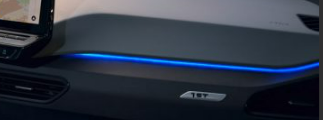

### Used Hardware and Libraries

Arduino Nano 33 Sense BLE rev.2 which has a brightness sensor on board.

Tensorflor Lite for microcontrollers libary for running the ML model on the arduino. (https://github.com/tensorflow/tflite-micro)

Install the following libaries from the Libary Manager in the Arduino IDE:
-  Arduino_APDS9960

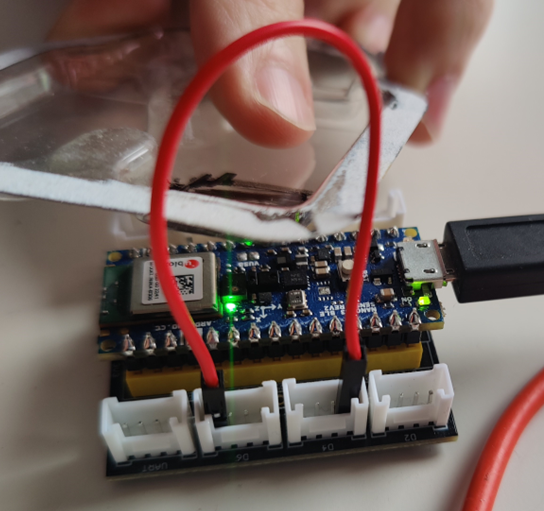

### Needed steps

1. Recording of good/ intended brightness curves
2. Train a model with the recorded curves and save it
3. Convert the saved model to to a Tensorflow Light (.tflite) file
4. Convert the tflite file into a C array within a header file
5. Create a Arduino sketch which uses the Tensorflow Light for microcontroller library, the C array model, and compares the prediction with the live sensor data.

## 1. Recording of good/ intended brightness curves

#### Steps to record

- Flash the Arduino sketch
- Disconnect the device and reconnect it again
- Directly after reconnecting start the python script for recording the serial monitor output.

Now we should have a proper TrainData.csv file

With the following sketch we will record 10 brightness curves (interior parts). Each measurement will take 10 seconds and records 40 data points.

To be able to record the data (as Arduino Serial Monitor has no option to export) we will use this python code running it in parallel.
Don't forget to change to change the com-port.

In [8]:
import serial

# Replace 'COM8' with your Arduino's serial port
ser = serial.Serial('COM8', 9600, timeout=1)

# Open a text file for writing
with open('TrainData.csv', 'w') as file:
    while True:
        line = ser.readline().decode('utf-8').strip()
        if line == "All measurements completed.":
            print("End of transmission.")
            break
        if line:
            print(line)
            file.write(line + '\n')

ser.close()

Measurement, Timestamp (ms), Ambient Light Intensity
1, 0, 512
1, 250, 512
1, 500, 510
1, 750, 506
1, 1000, 504
1, 1250, 500
1, 1500, 497
1, 1750, 495
1, 2000, 477
1, 2250, 460
1, 2500, 415
1, 2750, 334
1, 3000, 224
1, 3250, 143
1, 3500, 115
1, 3750, 92
1, 4000, 71
1, 4250, 64
1, 4500, 69
1, 4750, 73
1, 5000, 85
1, 5250, 90
1, 5500, 120
1, 5750, 146
1, 6000, 246
1, 6250, 409
1, 6500, 467
1, 6750, 500
1, 7000, 501
1, 7250, 503
1, 7500, 504
1, 7750, 505
1, 8000, 507
1, 8250, 508
1, 8500, 508
1, 8750, 507
1, 9000, 508
1, 9250, 508
1, 9500, 508
1, 9750, 507
2, 0, 507
2, 250, 507
2, 500, 507
2, 750, 505
2, 1000, 501
2, 1250, 501
2, 1500, 496
2, 1750, 470
2, 2000, 380
2, 2250, 270
2, 2500, 193
2, 2750, 158
2, 3000, 135
2, 3250, 110
2, 3500, 91
2, 3750, 94
2, 4000, 78
2, 4250, 91
2, 4500, 82
2, 4750, 91
2, 5000, 105
2, 5250, 131
2, 5500, 171
2, 5750, 252
2, 6000, 384
2, 6250, 454
2, 6500, 497
2, 6750, 501
2, 7000, 501
2, 7250, 505
2, 7500, 507
2, 7750, 507
2, 8000, 506
2, 8250, 506
2, 8500, 5

### Check, visualize and calculate the mean of the recorded data

       Measurement   Timestamp (ms)   Ambient Light Intensity
count   400.000000       400.000000                400.000000
mean      5.500000      4875.000000                335.707500
std       2.875878      2889.463184                185.524703
min       1.000000         0.000000                 62.000000
25%       3.000000      2437.500000                118.750000
50%       5.500000      4875.000000                432.500000
75%       8.000000      7312.500000                508.000000
max      10.000000      9750.000000                531.000000


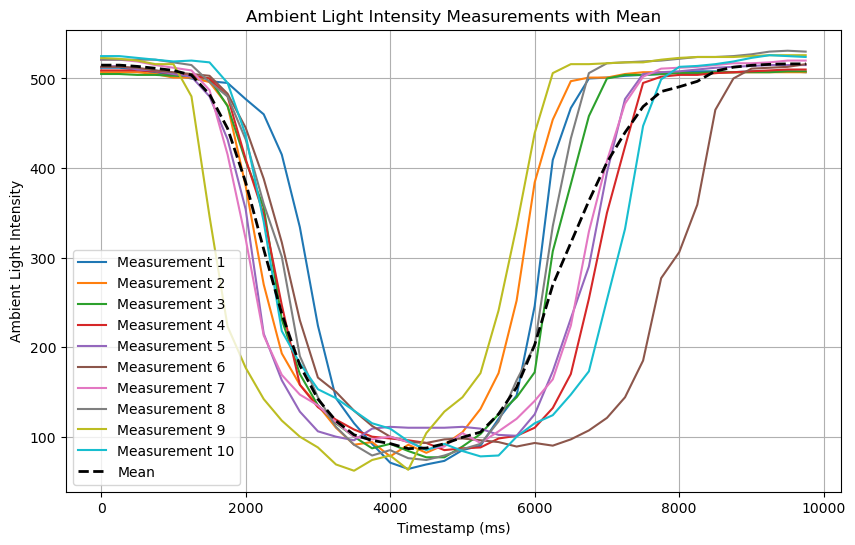

Mean of each timestamp over all measurements:
    Timestamp (ms)  Ambient Light Intensity
0                0                    514.9
1              250                    514.9
2              500                    513.5
3              750                    511.4
4             1000                    509.0
5             1250                    503.8
6             1500                    482.3
7             1750                    444.2
8             2000                    384.1
9             2250                    309.2
10            2500                    237.2
11            2750                    179.7
12            3000                    141.9
13            3250                    117.6
14            3500                    102.1
15            3750                     95.9
16            4000                     92.3
17            4250                     86.7
18            4500                     87.3
19            4750                     92.1
20            5000            

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('TrainData.csv')

# Check the column names
#print("Column names in the DataFrame:", df.columns)
print(df.describe())

# Remove leading and trailing whitespace from the column names
df.columns = df.columns.str.strip()

# Identify all unique measurements
unique_measurements = df['Measurement'].unique()

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each measurement
for measurement in unique_measurements:
    subset = df[df['Measurement'] == measurement]
    plt.plot(subset['Timestamp (ms)'], subset['Ambient Light Intensity'], label=f'Measurement {measurement}')

# Calculate the mean for each timestamp
mean_df = df.groupby('Timestamp (ms)')['Ambient Light Intensity'].mean().reset_index()

# Plot the means
plt.plot(mean_df['Timestamp (ms)'], mean_df['Ambient Light Intensity'], label='Mean', color='black', linestyle='--', linewidth=2)

# Customize the plot
plt.xlabel('Timestamp (ms)')
plt.ylabel('Ambient Light Intensity')
plt.title('Ambient Light Intensity Measurements with Mean')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Display the mean DataFrame
print("Mean of each timestamp over all measurements:")
print(mean_df)


## 2. Train a model with the recorded curves and save it

Lets create a simple neural network model by first prepare, normalize and create sequences (windowing). The model will use these sequences as input to learn temporal patterns. The target for each sequence is the next data point in the same measurement series.
Afterwarts we will save it as a .keras file.

Important: We will not optimize, trying different MLs (e.g. LSTM) or just using a statistical approach without ML, etc. The purpose here is to get to know the flow of bringing ML on an edge device with the TensorFlow Lite for microcontrollers library.

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Read the CSV file
df = pd.read_csv('TrainData.csv')

# Remove leading and trailing whitespace from the column names
df.columns = df.columns.str.strip()

# Select only the relevant columns
data = df[['Measurement', 'Timestamp (ms)', 'Ambient Light Intensity']]

# Normalize the data
scaler = MinMaxScaler()
data_normalized = data.copy()
data_normalized[['Timestamp (ms)', 'Ambient Light Intensity']] = scaler.fit_transform(data[['Timestamp (ms)', 'Ambient Light Intensity']])


# Extract the min and max values from the scaler
min_timestamp = scaler.data_min_[0]
max_timestamp = scaler.data_max_[0]
min_intensity = scaler.data_min_[1]
max_intensity = scaler.data_max_[1]

print("Min value of the timestamp:", min_timestamp)
print("Max value of the timestamp:", max_timestamp)
print("Min value of the ambient light intensity:", min_intensity)
print("Max value of the ambient light intensity:", max_intensity)

# Split the data into sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    current_measurement = data[0, 0]  # Initialize the current measurement series

    for i in range(len(data) - seq_length):
        if data[i + seq_length, 0] != current_measurement:
            current_measurement = data[i + seq_length, 0]
            continue  # Skip if the measurement series changes

        x = data[i:i + seq_length, 1:]  # Only the relevant features
        y = data[i + seq_length, 1:]  # Target is the next data point within the same measurement series

        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 8  # Length of the sequence
X, y = create_sequences(data_normalized.values, seq_length)
print(f"Anzahl der Sequenzen: {len(X)}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Create a simple model
model = Sequential()
model.add(Flatten(input_shape=(seq_length, 2)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=40, batch_size=32)

# Save the model in the new Keras format
model.save('anomaly_detection_model.keras')


Min value of the timestamp: 0.0
Max value of the timestamp: 9750.0
Min value of the ambient light intensity: 62.0
Max value of the ambient light intensity: 531.0
Anzahl der Sequenzen: 383
Shape of X: (383, 8, 2)
Shape of y: (383, 2)
Epoch 1/40
12/12 [==============================] - 0s 2ms/step - loss: 0.5182
Epoch 2/40
12/12 [==============================] - 0s 2ms/step - loss: 0.3288
Epoch 3/40
12/12 [==============================] - 0s 2ms/step - loss: 0.2086
Epoch 4/40
12/12 [==============================] - 0s 2ms/step - loss: 0.0648
Epoch 5/40
12/12 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 6/40
12/12 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 7/40
12/12 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 8/40
12/12 [==============================] - 0s 821us/step - loss: 0.0131
Epoch 9/40
12/12 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 10/40
12/12 [==============================] - 0

## Lets visualize our anomaly_detection_model

I am using the open-source web tool https://netron.app for visualizing the model’s structure, including layers, connections, input/output shapes, and parameters.

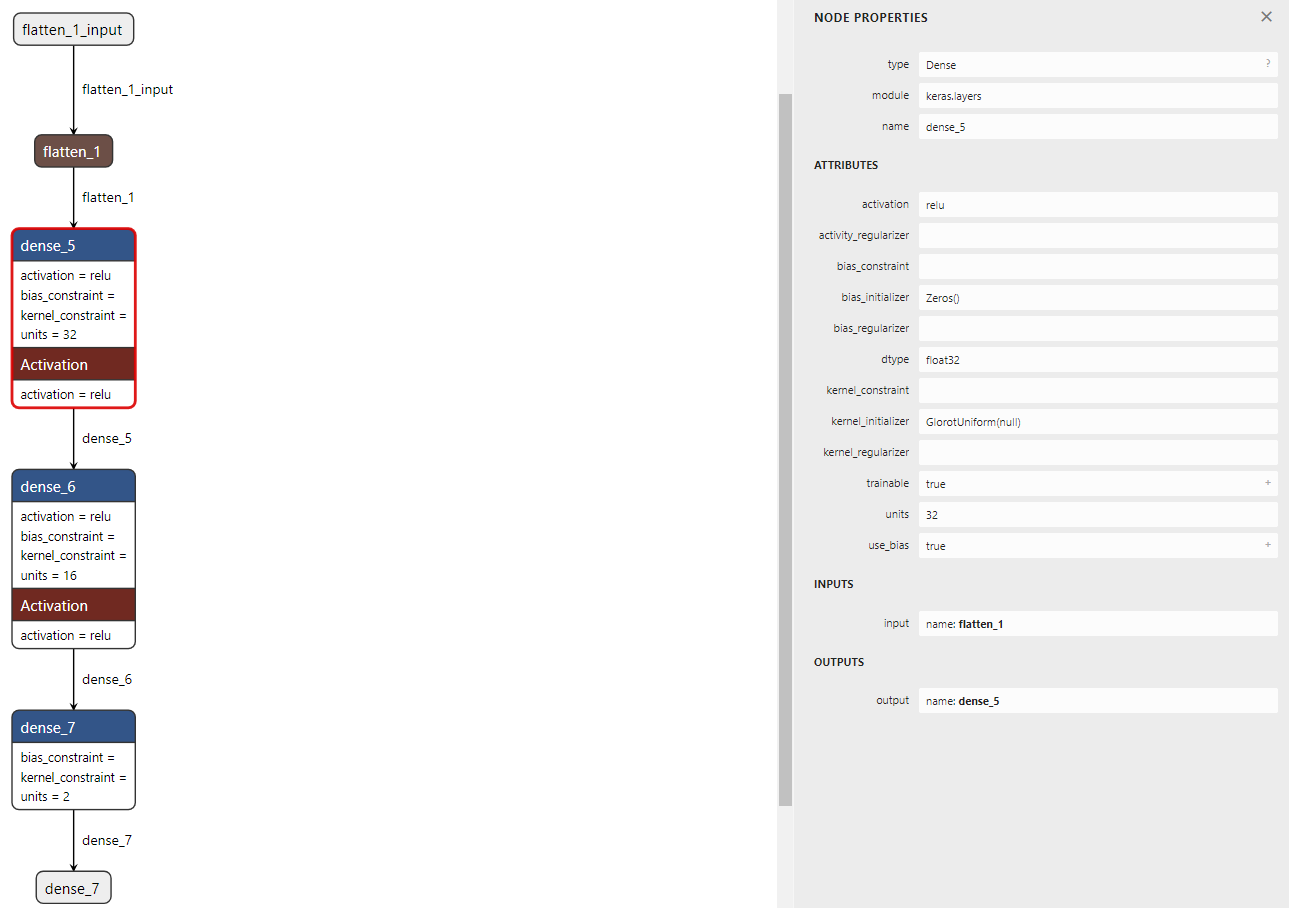

## 3. Convert the saved model to to a TensorFlow Light (.tflite) file

Now we need to convert the TensorFlow .kreras model to a TensorFlow Light .tflite file using the TFLiteConverter. It performs several key tasks to transform a TensorFlow model into a TFLite model that is optimized for deployment on resource-constrained devices:

- Simplifies and prunes the computational graph.
- Applies various forms of quantization to reduce model size and improve performance.
- Uses optimized operators and kernels designed for mobile and embedded hardware.
- Optimizes memory usage and tensor layout for efficient inference.
- Prepares the model for hardware acceleration, if applicable.
- Serializes the model into a compact and efficient FlatBuffer format.



For more information regards the converter optimizations: https://www.tensorflow.org/lite/performance/model_optimization

In [24]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('anomaly_detection_model.keras')

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('anomaly_detection_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Chris\AppData\Local\Temp\tmp2_y4v_r3\assets


INFO:tensorflow:Assets written to: C:\Users\Chris\AppData\Local\Temp\tmp2_y4v_r3\assets


## 4. Convert the tflite file into a C array within a header file

To be able to use the model directly in our Code/ Arduino sketch, we have to convert the model into a C array by using xxd.

Run this command in your terminal being in the same directory: 

'xxd -i anomaly_detection_model.tflite > anomaly_detection_model.h'

Once you have generated the file, you can include it in your program. It is important to change the array declaration to const for better memory efficiency on embedded platforms.



For more information, see: https://www.tensorflow.org/lite/microcontrollers/build_convert

## 5.Create an Arduino sketch which uses the TensorFlow Light for microcontroller libary, the C array model, and compares the prediction with the live sensor data.

Okay now lets create an Arduino sketch using TensorFlow Light for microcontroller library and the prepared model within the C array in the anomaly_detection_model.h.

The sketch has this high level structure:
- Including needed libraries
- Prepare TensorFlow Data structures
- Prepare Variables
- Prepare the setup function
- Prepare the loop function

At the end of this chapter you will find the complete arduino sketch. So lets take a look at each code section from the sketch and try to understand what we have to do and why its needed.

### Include libraries

**#include <Arduino.h>:**
Purpose: Provides the core functions and definitions needed to interact with the microcontroller hardware in an Arduino environment.

**#include <TensorFlowLite.h>:**
Purpose: Provides the main TensorFlow Lite for Microcontrollers library, enabling the loading and execution of machine learning models on microcontrollers.

**#include <tensorflow/lite/micro/all_ops_resolver.h>:**
Purpose: This header file includes the AllOpsResolver class, which is used to register all the operations (like addition, multiplication, convolution, etc.) that might be needed by the TensorFlow Lite model running on the microcontroller. It essentially tells the interpreter which operations are available and ensures that the model can use any operation it needs to perform inference correctly.

**#include <tensorflow/lite/micro/tflite_bridge/micro_error_reporter.h>:**
Purpose: This header provides access to the MicroErrorReporter class, which is responsible for logging and reporting errors within TensorFlow Lite for Microcontrollers. It's essential for debugging, as it helps identify issues during model initialization, tensor allocation, and inference by printing out error messages to the serial monitor or other debugging outputs.

**#include <tensorflow/lite/micro/micro_interpreter.h>:**
Purpose: This file includes the MicroInterpreter class, which is the core component that runs the TensorFlow Lite model on the microcontroller. It handles the entire process of loading the model, setting up input and output tensors, allocating memory, and executing the model to produce predictions. The MicroInterpreter is crucial for integrating machine learning capabilities into your microcontroller project.

**#include <tensorflow/lite/schema/schema_generated.h>:**
Purpose: This header defines the data structures and constants that are generated from the TensorFlow Lite FlatBuffer schema. The schema specifies the format and organization of data within a TensorFlow Lite model. This header ensures that the model's data is correctly parsed and interpreted by the interpreter, verifying that the model version and structure match what the interpreter expects.

**#include <Arduino_APDS9960.h>:**
Purpose: This header provides the interface to the APDS-9960 sensor, which is a versatile sensor capable of detecting ambient light, RGB color, and gestures. The library included with this header allows your Arduino code to initialize the sensor, read data such as ambient light intensity, and use that data as input for the machine learning model.

### Prepare TensorFlow Data structures

/*#### Prepare Tensorflow Data structures ####*/  
**tflite::MicroErrorReporter micro_error_reporter;**  // Object for handling and reporting errors during TensorFlow Lite operations  
**tflite::ErrorReporter\* error_reporter = &micro_error_reporter;**  // Pointer to the error reporter, used by the interpreter to log errors  
**tflite::AllOpsResolver micro_op_resolver;**  // Resolver that includes all TensorFlow Lite operations available for use in the model  
**tflite::MicroInterpreter\* interpreter;**  // Pointer to the MicroInterpreter, which runs the TensorFlow Lite model on the microcontroller  
**TfLiteTensor\* input;**  // Pointer to the input tensor, where the model’s input data will be stored  
**TfLiteTensor\* output;**  // Pointer to the output tensor, where the model’s prediction results will be stored  

// Define model and input data  
**constexpr int tensor_arena_size = 2 * 1024;**  // Size of memory (in bytes) to allocate for model execution, including input/output tensors  
**alignas(16) uint8_t tensor_arena[tensor_arena_size];**  // Memory buffer aligned to 16 bytes, used to store tensors (input/output) and intermediate computations during model inference

## Prepare Variables

Lets set up the variables we need.
- **seq_length:** The sequence length specifies how many data points are used in a sequence that will be fed into the machine learning model and are used to predict the next value (and what will be then compared later with the actual one)
- **num_samples:** how many measurement will be taken within one measurement recording
- **measurement_data:** storing the measured data
- **xxx_:** the min/max values from our recorded train data which we printed in chapter "2. Train a model with the recorded curves and save it"


## Prepare the setup() function

**0. Prepare Serial communication, HW Button, brightness sensor**

**For TensorFlow**




1. Model Loading: The code first loads the model and checks its compatibility.  
2. Interpreter Initialization: It initializes the TensorFlow Lite interpreter using the model and allocates memory for the tensors.  
3. Tensor Allocation: It allocates memory for the model’s input and output tensors, ensuring everything is set up for inference.
4.  Input/Output Setup: Finally, it retrieves pointers to the input and output tensors, which will be used during inference to feed data into the model and get predictions out of it.

If you are interested in even more information, take a look in the book: "Tinyml: Machine Learning with TensorFlow Lite on Arduino and Ultra-Low-Power Microcontrollers, 2019"
Especially from page 74 | Chapter 5: The “Hello World” of TinyML: Building an Application

**1. Loading the Model**

***'const tflite::Model\* model = tflite::GetModel(anomaly_detection_model_tflite);'***

Explanation: This line loads the TensorFlow Lite model from our C array anomaly_detection_model_tflite in "anomaly_detection_model.h"

***if (model->version() != TFLITE_SCHEMA_VERSION) {
    Serial.println("Model provided is schema version not equal to supported version.");
    while (1);
}***

Explanation: This checks if the loaded model's version matches the TensorFlow Lite schema version that the interpreter expects. The schema version is a set of rules that define how the model data is structured. This is a safety check to ensure compatibility between the model and the interpreter.


**2. Initializing the Interpreter**

***static tflite::MicroInterpreter static_interpreter(model, micro_op_resolver, tensor_arena, tensor_arena_size);  
interpreter = &static_interpreter;***

Explanation: Here, a MicroInterpreter object named static_interpreter is created using the model, the operation resolver (micro_op_resolver), and a block of memory (tensor_arena) to hold the model's tensors (data structures used during inference). The tensor_arena_size specifies the size of this memory block. The interpreter is then assigned to a global pointer interpreter so it can be accessed throughout the program. The MicroInterpreter is responsible for running the TensorFlow Lite model on the microcontroller.


**3. Allocating Memory for Tensors**

***TfLiteStatus allocate_status = interpreter->AllocateTensors();***

Explanation: This line calls the AllocateTensors() method of the interpreter, which sets up the necessary memory for the model's input and output tensors. This step is crucial because it prepares the model to process input data and produce output.


***if (allocate_status != kTfLiteOk) {
    Serial.println("AllocateTensors() failed");
    while (1);
}***

Explanation: This checks if the tensor allocation was successful. AllocateTensors() returns a status code (TfLiteStatus).


**4. Setting Up Input and Output Tensors**

***input = interpreter->input(0);  
output = interpreter->output(0);***

Explanation: These lines retrieve pointers to the model’s input and output tensors. The input(0) and output(0) methods refer to the first (and typically only) input and output tensors of the model, respectively. These pointers are then stored in the global variables input and output so that data can be fed into the model and results can be read from the model after inference.

## Prepare the loop function

Within the loop function we will to the inference and implement different steps:
- Press a connected HW button (or just put the pin on GND with a jumper cable) to start a Measurement
- Measure the brightness curve of a new part
- Split the measurement into sequences and normalize the data as done for the model training and store it in the input tensor
- Run the model on the sequence and store the predictions in the output tensor
- Compare the prediction with the actual data by first recalculating it back to the original scale and then calculate deviation.
- Define absolute and percentage thresholds and print them.

## Here you will find the complete sketch from 'Light_intensity_anomaly_detection_ML.ino'

## Analyze the new Measurement and plot the results

Lets plot the predicted, actual and detected anomalies by simply copying the printed lines with includes the actual and predicted values from the Arduino IDE serial monitor and put the string in a variable.

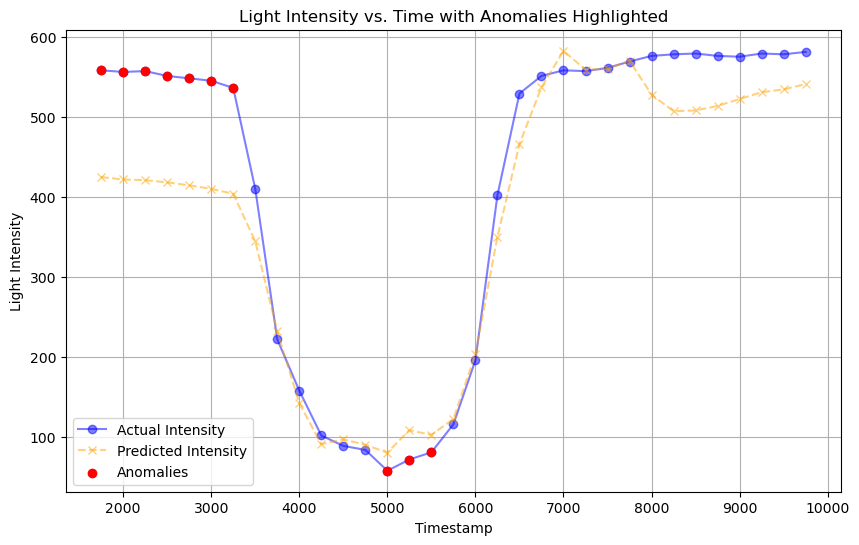

In [15]:
import re

# String containing the data
data = """
13:19:14.766 -> Anomaly detected at timestamp: 1750.00 | Actual: 558.00 | Predicted: 424.64 | Absolute deviation: 133.36 | Percent deviation: 23.90%
13:19:14.766 -> Anomaly detected at timestamp: 2000.00 | Actual: 556.00 | Predicted: 421.69 | Absolute deviation: 134.31 | Percent deviation: 24.16%
13:19:14.766 -> Anomaly detected at timestamp: 2250.00 | Actual: 557.00 | Predicted: 420.82 | Absolute deviation: 136.18 | Percent deviation: 24.45%
13:19:14.766 -> Anomaly detected at timestamp: 2500.00 | Actual: 551.00 | Predicted: 418.16 | Absolute deviation: 132.84 | Percent deviation: 24.11%
13:19:14.766 -> Anomaly detected at timestamp: 2750.00 | Actual: 548.00 | Predicted: 414.36 | Absolute deviation: 133.64 | Percent deviation: 24.39%
13:19:14.766 -> Anomaly detected at timestamp: 3000.00 | Actual: 545.00 | Predicted: 410.00 | Absolute deviation: 135.00 | Percent deviation: 24.77%
13:19:14.766 -> Anomaly detected at timestamp: 3250.00 | Actual: 536.00 | Predicted: 403.81 | Absolute deviation: 132.19 | Percent deviation: 24.66%
13:19:14.766 -> Normal at timestamp: 3500.00 | Actual: 410.00 | Predicted: 344.53 | Absolute deviation: 65.47 | Percent deviation: 15.97%
13:19:14.766 -> Normal at timestamp: 3750.00 | Actual: 222.00 | Predicted: 231.92 | Absolute deviation: 9.92 | Percent deviation: 4.47%
13:19:14.799 -> Normal at timestamp: 4000.00 | Actual: 158.00 | Predicted: 142.23 | Absolute deviation: 15.77 | Percent deviation: 9.98%
13:19:14.799 -> Normal at timestamp: 4250.00 | Actual: 102.00 | Predicted: 91.18 | Absolute deviation: 10.82 | Percent deviation: 10.61%
13:19:14.799 -> Normal at timestamp: 4500.00 | Actual: 89.00 | Predicted: 97.21 | Absolute deviation: 8.21 | Percent deviation: 9.22%
13:19:14.799 -> Normal at timestamp: 4750.00 | Actual: 84.00 | Predicted: 90.39 | Absolute deviation: 6.39 | Percent deviation: 7.60%
13:19:14.799 -> Anomaly detected at timestamp: 5000.00 | Actual: 58.00 | Predicted: 80.65 | Absolute deviation: 22.65 | Percent deviation: 39.05%
13:19:14.799 -> Anomaly detected at timestamp: 5250.00 | Actual: 72.00 | Predicted: 108.60 | Absolute deviation: 36.60 | Percent deviation: 50.84%
13:19:14.799 -> Anomaly detected at timestamp: 5500.00 | Actual: 81.00 | Predicted: 102.78 | Absolute deviation: 21.78 | Percent deviation: 26.89%
13:19:14.799 -> Normal at timestamp: 5750.00 | Actual: 116.00 | Predicted: 122.68 | Absolute deviation: 6.68 | Percent deviation: 5.76%
13:19:14.799 -> Normal at timestamp: 6000.00 | Actual: 196.00 | Predicted: 203.54 | Absolute deviation: 7.54 | Percent deviation: 3.85%
13:19:14.799 -> Normal at timestamp: 6250.00 | Actual: 402.00 | Predicted: 350.12 | Absolute deviation: 51.88 | Percent deviation: 12.90%
13:19:14.830 -> Normal at timestamp: 6500.00 | Actual: 529.00 | Predicted: 465.80 | Absolute deviation: 63.20 | Percent deviation: 11.95%
13:19:14.830 -> Normal at timestamp: 6750.00 | Actual: 551.00 | Predicted: 536.73 | Absolute deviation: 14.27 | Percent deviation: 2.59%
13:19:14.830 -> Normal at timestamp: 7000.00 | Actual: 558.00 | Predicted: 582.48 | Absolute deviation: 24.48 | Percent deviation: 4.39%
13:19:14.830 -> Normal at timestamp: 7250.00 | Actual: 557.00 | Predicted: 558.64 | Absolute deviation: 1.64 | Percent deviation: 0.29%
13:19:14.830 -> Normal at timestamp: 7500.00 | Actual: 561.00 | Predicted: 560.01 | Absolute deviation: 0.99 | Percent deviation: 0.18%
13:19:14.830 -> Normal at timestamp: 7750.00 | Actual: 569.00 | Predicted: 569.94 | Absolute deviation: 0.94 | Percent deviation: 0.16%
13:19:14.830 -> Normal at timestamp: 8000.00 | Actual: 576.00 | Predicted: 527.65 | Absolute deviation: 48.35 | Percent deviation: 8.39%
13:19:14.830 -> Normal at timestamp: 8250.00 | Actual: 578.00 | Predicted: 506.95 | Absolute deviation: 71.05 | Percent deviation: 12.29%
13:19:14.830 -> Normal at timestamp: 8500.00 | Actual: 579.00 | Predicted: 507.90 | Absolute deviation: 71.10 | Percent deviation: 12.28%
13:19:14.870 -> Normal at timestamp: 8750.00 | Actual: 576.00 | Predicted: 513.53 | Absolute deviation: 62.47 | Percent deviation: 10.85%
13:19:14.870 -> Normal at timestamp: 9000.00 | Actual: 575.00 | Predicted: 522.20 | Absolute deviation: 52.80 | Percent deviation: 9.18%
13:19:14.870 -> Normal at timestamp: 9250.00 | Actual: 579.00 | Predicted: 530.68 | Absolute deviation: 48.32 | Percent deviation: 8.35%
13:19:14.870 -> Normal at timestamp: 9500.00 | Actual: 578.00 | Predicted: 534.16 | Absolute deviation: 43.84 | Percent deviation: 7.58%
13:19:14.870 -> Normal at timestamp: 9750.00 | Actual: 581.00 | Predicted: 540.81 | Absolute deviation: 40.19 | Percent deviation: 6.92%
"""

# Extract data using regex
timestamps = [float(x) for x in re.findall(r'timestamp: (\d+\.?\d*)', data)]
actual_values = [float(x) for x in re.findall(r'Actual: (\d+\.?\d*)', data)]
predicted_values = [float(x) for x in re.findall(r'Predicted: (-?\d+\.?\d*)', data)]
anomalies = ['Anomaly' in match for match in re.findall(r'(Anomaly detected|Normal)', data)]

plt.figure(figsize=(10, 6))

# Plot actual and predicted values
plt.plot(timestamps, actual_values, label='Actual Intensity', color='blue', marker='o', alpha=0.5)
plt.plot(timestamps, predicted_values, label='Predicted Intensity', color='orange', linestyle='--', marker='x', alpha=0.5)

# Mark anomalies
anomaly_timestamps = [timestamps[i] for i in range(len(timestamps)) if anomalies[i]]
anomaly_actual_values = [actual_values[i] for i in range(len(actual_values)) if anomalies[i]]
plt.scatter(anomaly_timestamps, anomaly_actual_values, color='red', label='Anomalies', zorder=5)

plt.xlabel('Timestamp')
plt.ylabel('Light Intensity')
plt.title('Light Intensity vs. Time with Anomalies Highlighted')
plt.legend()
plt.grid(True)
plt.show()


## Conclusion

In this project we learned a lot about performing ML on the edge (Arduino Nano 33 Sense BLE rev.2) by simulating a quality assurance test for checking the light intensity from light guides interior parts.
So we learned:

- How to record the of good/ intended brightness curves as reference/ training data
- To train a model with TensorFlow the recorded curves and save it
- To convert the saved model to to a TensorFlow Light (.tflite) file
- To convert the tflite file into a C array within a header file to be able to use in on the microcontroller within the arduino sketch
- How to create a Arduino sketch which uses the TensorFlow Light for microcontroller library and what are the needed TensorFlow data structs and functions
-  To compares the prediction with the live sensor data.

I hope you had fun and also learned something :)

If you want to see more articles and want to support me, then buy me a coffee: 
<a href="https://buymeacoffee.com/dsite42" target="_blank">
    <img src="attachment:bb37c704-37c6-47f3-a475-48f22c2d9421.png" alt="image.png">
</a>

If you have suggestions for improvement or found any mistake, please let me know.

